# Function descriptions

Before answering the PSET questions, I want to quickly run through what each function defined in the scripts in PSET4_functions does...

## misc.py

**Cleaning data** 

Defining a helper function that takes loaded Matlab data and returns a jm length matrix, ordered in cycles of j within cycles of m, with 
- shares for each product in each market (sjm)
- prices for each product in each market (pjm)
- supply-side features for each product in each market (wj, zjm, etajm)
- demand-side features for each product in each market (xijm, X1jm, X2jm, X3jm)

**Consumer surplus** 
- consumer_surplus_m(params, demand_features_m, v): given a set of market-level utility parameters $(\beta_1, \beta_2, \beta_3, \alpha, \sigma_{\alpha})$ and a matrix of demand features $(X_{1jm}, X_{2jm}, X_{3jm}, p_{jm})$, and a $v_i$, compute the optimal purchasing decision and corresponding welfare.
- consumer_surplus(params, demand_features_long, random_vs, num_prods): aggregate across draws of $v_i$, and return vector of consumer surplus for each market.

**Profits**
- profits_m(gammas, supply_features_m, shares_m, prices_m, num_vs): given a set of market-level supply parameters $(\gamma_0, \gamma_1, \gamma_2)$ and a matrix of supply features $(W_{j}, Z_{jm}, \eta_{jm})$, compute marginal cost, and profit $(M * s_{jm} * (p_{jm} - mc_{jm}))$.
- profits(gammas, supply_features_long, shares_long, prices_long, num_prods, num_vs): calculate profits_m market by market.
- marginal_cost_m: same as profits, but returns marginal cost
- marginal_cost: same as profits, but returns marginal cost

## shares.py

Defining a few functions that I'll be using in my inner loop (or just for my MPEC). They are...

**Share functions**
- $shares\_im(\theta_2, \delta_m, p_m, v_i)$: returns vector of shares for each product given market/person, i.e. for ($i$, $m$) returns $s_{ijm} = \frac{\exp(\delta_{jm} + \mu_{ijm}(\theta_2))}{1 + \sum_k \exp(\delta_{km} + \mu_{ikm}(\theta_2))}$, where $\mu_{ijm}(\theta_2) = -\theta_2 v_i p_{jm}$
- $shares\_m(\theta_2, \delta_m, p_m, \{v_i\})$: Given a guess of $\theta_2$, a $\delta_m$, and a vector of random $v_i$ drawn from the LN(0,1) distribution, return a vector of the estimated shares for each product in a given market according to the generic approach outlined in the slides: for market $m$, returns vector of $\hat{s_{m}} = \frac{1}{N} \sum_i^N shares\_im(p_m, \delta_m, \theta_2, v_i)$
- $shares(\theta_2, \delta, p, \{v_i\})$: Returns vector \{$shares\_m(p_m, \delta_m, \theta_2, \{v_i\})\}_{m \in M}$, i.e. averaged shares for each market (I flatten the 2-d array to make constraints). This is what I'll use for my MPEC. 

**Analytic derivatives**

In a parallel structure to above (construct at the $im$ level, aggregate across $v_i$, and then aggregate across $m$), I construct $\frac{ds}{d\theta_2}$ and $\frac{ds}{d\delta}$. Note that for $\frac{ds}{d\delta}$ I use "Gaston's trick" as relayed by Tomas (super helpful, basically multiply matrices to give me the terms I need).

- $shares\_im\_ddelta$ 
- $shares\_m\_ddelta$ 
- $shares\_ddelta$
- $shares\_im\_dtheta2$ 
- $shares\_m\_dtheta2$
- $shares\_dtheta2$ 

## delta.py
Defining some functions to give me a "good" initial delta guess, i.e. that makes the shares constraint hold. I do this by solving the BLP inner loop.
- $logit\_delta(\mathbb{S})$: given matrix of actual shares, return the logit delta, which I'll use as my initial guess for the inner loop. From the slides, the logit delta is $\delta = lns_j - lns_O$
- $contraction\_map\_m(\delta_0(m), \theta_2,\log(\mathbb{S}_m), p_m, \{v_i\})$: solve the true $\delta$ values in market m given a $\theta_2$, via the contraction mapping as written in Conlon and Gortomaker (2020), i.e. $\delta_m^{h+1} = \delta_m^h + \ln(\mathbb{S_m}) - \ln(shares(\delta_m^h, \theta_2, ...)$
- $inner\_loop(\theta_2, \delta_0,\log(\mathbb{S}_m), p_m, \{v_i\})$: runs contraction_map_m on each market, returns resulting delta

## moments.py

Defining some functions I'll use to construct my moments (for the outer loop and the MPEC)...

- hausman_instruments(p_wide): given price data in "wide" form (mXj), construct Hausman instrument: $\frac{1}{M-1} \sum_{n \neq m} P_{jn}$
- blp_instruments(x_3d): given a 3d matrix of mXjXcharacteristics (so 100X3X3) construct the BLP instruments matrix: $[x_{1jm}, x_{2jm}, x_{3jm}, \sum_{k \neq j} x_{2km}, \sum_{k \neq j} x_{3km}]$.
- g(delta, prices_wide, x_long, x_3d): construct moments $Z * \hat{\xi}$, where $\hat{\xi}$ is the residuals of an GMM IV of $Z$ on $\delta = \beta X + \alpha P$, i.e. $(I - X (X' P_z X)^{-1} X P_z) \delta$.
- g_ddelta(delta, prices_wide, x_long, x_3d): returns analytic derivative (just residual maker matrix for now; going to be a mess when I start joint estimating supply and demand).
- g_jm: construct moments observation by observation (i.e. by jm). I need this to estimate analytic SEs.

# mpec_wrapper.py

- mpec_objective: objective function for my MPEC
- mpec_gradient: gradient for my MPEC
- mpec_jacobian: jacobian for my MPEC (putting together the pieces as defined by functions above)
- beta_alpha: recover $\beta$ and $\alpha$ from the results of my MPEC
- standard_errors: recovers analytic SEs for $\beta$, $\alpha$, and $\sigma_\alpha$, via...
    1. calculating $V_{GMM}$ for $\theta_2$ with $W=I$, i.e. $[G'G]^{-1}G'BG[G'G]^{-1}$, where $G = \frac{dg}{d\theta_2} = Z_{jt} (\frac{ds}{d\delta}^{-1} \frac{ds}{d\theta_2})$, $B = \frac{1}{JT} \sum_{j,t}g(\theta_2)g'(\theta_2)$
    2. recover variance for $\alpha, \beta$ via delta method, i.e. for $C = (X' P_Z X)^{-1} X' P_Z$, $[\alpha, \beta] = C \delta(\theta_2) = f(\theta_2)$. Note that $f'(theta_2) = C \frac{d\delta}{d\theta_2} = C (\frac{ds}{d\delta}^{-1} \frac{ds}{d\theta_2})$, and via delta method if $\theta_2 ~ N(0, \sigma^2)$, $[alpha, \beta] ~ N(0, f'(theta_2)^2 \sigma^2$ 

# Question 1

Below are histograms of prices, profits, and consumer surplus for the 100 market, 3 products dataset. I calculate profits using the true $\gamma$ values, (5, 1, 1), and consumer surplus using the true $\beta, \alpha, \sigma_{\alpha}$ values, ((5,1,1), 1, 1).

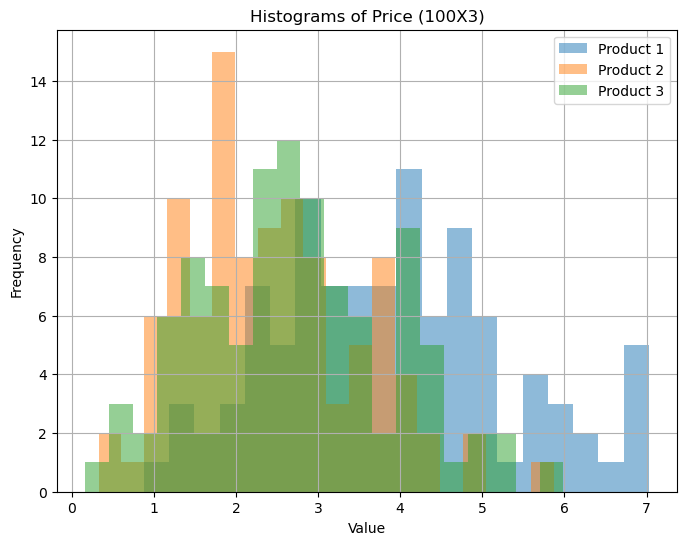

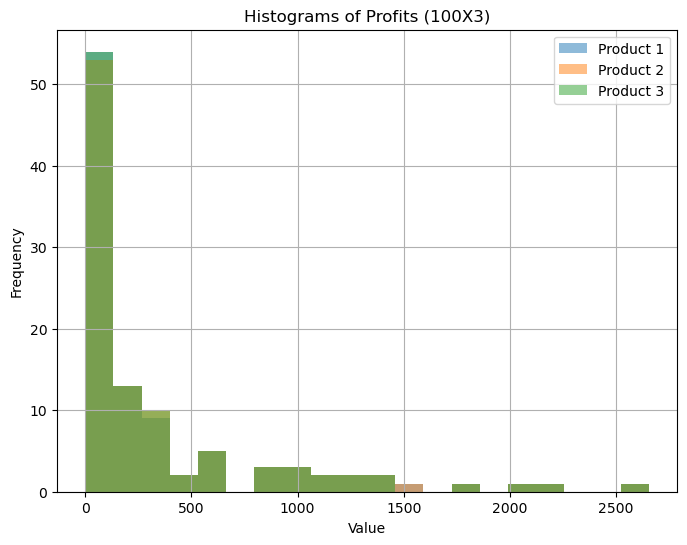

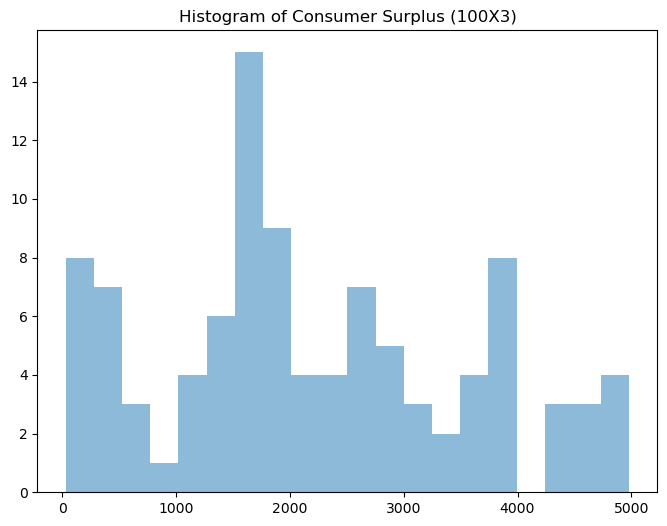

In [1]:
# Pre-question, loading libraries and data
import numpy as np
from scipy.io import loadmat
import jaxopt as jaxopt
import matplotlib.pyplot as plt
from PSET4_functions.misc import *

m100_j3 = loadmat("data/100markets3products.mat")
dat = clean_data(m100_j3, 3)

demand_features_data_long = dat[["X1jm", "X2jm", "X3jm", "pjm", "xijm"]].to_numpy()
supply_features_data_long = dat[['wj', 'zjm', 'etajm']].to_numpy()
shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy()

np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

prices_data_wide = prices_data_long.reshape(100, 3)
consumer_surplus_data = consumer_surplus((5, 1, 1, -1, 1), demand_features_data_long, random_vs, 3)
profits_data = profits((2,1,1), supply_features_data_long, shares_data_long, prices_data_long, 3, len(random_vs))

# Define product names
product_labs = ['Product 1', 'Product 2', 'Product 3']

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))

for i in range(prices_data_wide.shape[1]):
    plt.hist(prices_data_wide[:, i], bins=20, alpha=0.5, label=product_labs[i])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Price (100X3)')
plt.legend()
plt.grid(True)
plt.show()

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))

for i in range(profits_data.shape[1]):
    plt.hist(profits_data[:, i], bins=20, alpha=0.5, label=product_labs[i])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Profits (100X3)')
plt.legend()
plt.grid(True)
plt.show()

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))
plt.hist(consumer_surplus_data, bins=20, alpha=0.5)
plt.title('Histogram of Consumer Surplus (100X3)')
plt.show()


Below are the same results, but using the 100 market, 5 product dataset. 

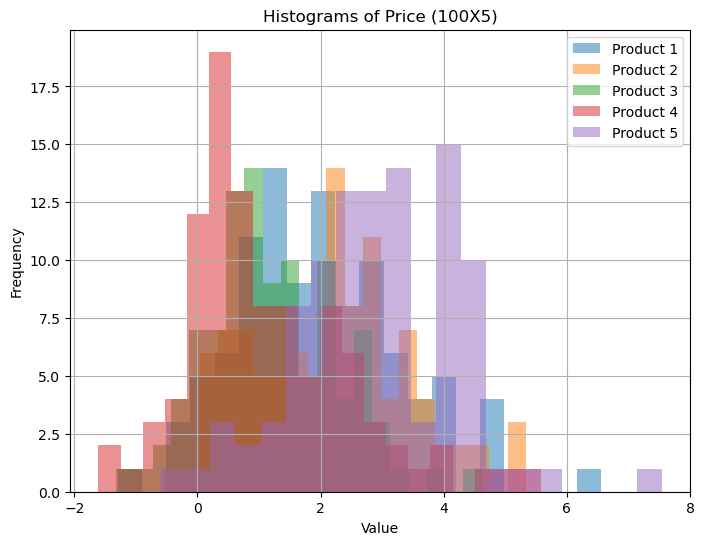

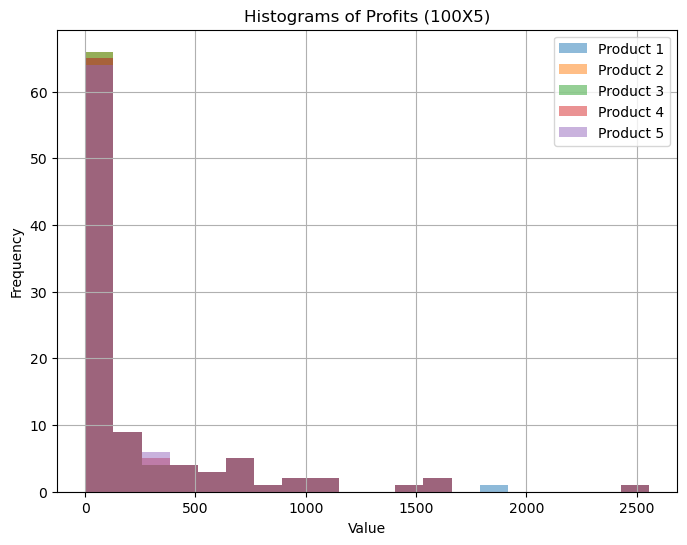

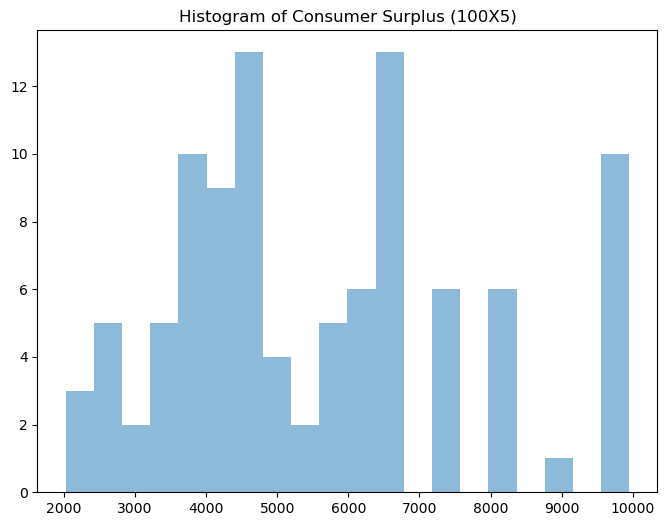

In [2]:
# Pre-question, loading libraries and data
import numpy as np
from scipy.io import loadmat
import jaxopt as jaxopt
import matplotlib.pyplot as plt
from PSET4_functions.misc import *

m100_j5 = loadmat("data/100markets5products.mat")
dat = clean_data(m100_j5, 5)

demand_features_data_long = dat[["X1jm", "X2jm", "X3jm", "pjm", "xijm"]].to_numpy()
supply_features_data_long = dat[['wj', 'zjm', 'etajm']].to_numpy()
shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy()

np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

prices_data_wide = prices_data_long.reshape(100, 5)
consumer_surplus_data = consumer_surplus((5, 1, 1, -1, 1), demand_features_data_long, random_vs, 5)
profits_data = profits((2,1,1), supply_features_data_long, shares_data_long, prices_data_long, 5, len(random_vs))

# Define product names
product_labs = ['Product 1', 'Product 2', 'Product 3', 'Product 4', 'Product 5']

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))

for i in range(prices_data_wide.shape[1]):
    plt.hist(prices_data_wide[:, i], bins=20, alpha=0.5, label=product_labs[i])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Price (100X5)')
plt.legend()
plt.grid(True)
plt.show()

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))

for i in range(profits_data.shape[1]):
    plt.hist(profits_data[:, i], bins=20, alpha=0.5, label=product_labs[i])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histograms of Profits (100X5)')
plt.legend()
plt.grid(True)
plt.show()

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))
plt.hist(consumer_surplus_data, bins=20, alpha=0.5)
plt.title('Histogram of Consumer Surplus (100X5)')
plt.show()


# Question 2

## 2.1

a) The values of $E[\xi_{jm} X_{jm}]$, $E[\xi_{jm} p_{jm}]$, and $E[\xi_{jm} \bar{p_{jm}}]$ can be seen below. 

b) The first moment and the last moment are valid and (semi) relevant (RE my conversation with Gaston, our own characteristics are relevant instruments for construcing $\hat{ksi}$, but "weak" for our overall MPEC as by construction those $Z$ are almost perfectly orthogonal to $\hat{ksi}$). The first moment is part of the BLP instrument set (the whole set is $[x_{1jm}, x_{2jm}, x_{3jm}, \sum_{k \neq j} x_{2km}, \sum_{k \neq j} x_{3km}]$) and the last moment is a Hausman instrument. The second moment is neither relevent nor valid; prices are obviously endogenous. Not sure if I was supposed to test for relevance of the Hausman instrument; I suppose I indirectly do by seeing how my estimates respond by including BLP and Hausman instruments, as oppose to just BLP (they get better, so that suggests Hausman is both relevant and valid in this setting).

c) You can use both BLP and Hausman instruments in this setting (I do below, and my convergence gets faster and my estimates get better). Again, didn't explicitly test for Hausman relevance; not sure if that was intention of question.

In [3]:
# Pre-question, loading libraries and data
from scipy.io import loadmat
import jaxopt as jaxopt
from PSET4_functions.misc import *
from PSET4_functions.shares import *
from PSET4_functions.moments import * 
from PSET4_functions.mpec_wrapper import *

m100_j3 = loadmat("data/100markets3products.mat")
dat = clean_data(m100_j3, 3)
prices_data_long = dat[["pjm"]].to_numpy()
prices_data_wide = prices_data_long.reshape(100, 3)
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()
xi_data_long = dat[['xijm']].to_numpy()
hausman_instruments_data = hausman_instruments(prices_data_wide)

results = [["E[ksi p]", (xi_data_long.flatten() @ prices_data_long)/300], 
           ["E[ksi X]", (xi_data_long.flatten() @ x_data_long)/300], 
           ["E[ksi p_bar]", (xi_data_long.flatten() @ hausman_instruments_data)/300]]
results = [[name, value.tolist()] for name, value in results]
headers = ["estimates"]
print(tabulate(results, headers, tablefmt="plain"))

              estimates
E[ksi p]      [0.29495813714897284]
E[ksi X]      [0.04346103701850776, 0.020741922402260037, 0.03553150322946499]
E[ksi p_bar]  0.14367954767468022


## 2.2

a) My BLP moments are $E[\xi | Z] = 0$, for $Z = \{x_{1jm}, x_{2jm}, x_{3jm}, \sum_{k \neq j} x_{2km}, \sum_{k \neq j} x_{3km}\}$

b, c, d) 

See code (my Jupyter notebook has it pretty well documented). I estimate via MPEC, and calculate the gradient and Jacobian analytically, then feed that to my solver.

e, f, g) 

See results below. I also report parameter estimates and SEs using BLP and Hausman instruments at once, which I prefer (I get faster convergence to "more true" values). I plot a histogram of my estimated consumer surplus vs. the real values; I also print the matrix of price elasticity of demand for the results just using BLP instruments (not the best representation, but you can see sensible values; 3X3 block matrices with negative on the diagonals and positive values everywhere else, i.e. sensible substitution patterns). I don't do profits, since I'm not sure why that's in this section; to estimate profits via my MPEC results, I have to back out marginal cost by estimating mark-up, and doesn't that wait till part 3? 

I get pretty stable convergence for all parameters; go to same values at .01, .1, 1, 10 (those were the ones I tried for all my MPEC estimates; I think it works further up too, though you made need to go the MPEC wrapper function and push up max iterations). I need to bound it though; if I guess .01 or lower, it falls below 0 and gets stuck at a saddle point. Don't feel too bad about that though; it would be silly to guess below 0 (I subtract my $\sigma_\alpha$). 

When I drop to the 10X3 dataset, convergence is less stable and I get incorrect estimates, which is exactly what you'd expect. I find it weird that the SEs are still small though; the $\sigma_\alpha$ estimate is $\theta_2$, and I recover the SE from that via $V_{GMM}$, i.e. the variance covariance matrix of the GMM estimator. Surely my gradient $\frac{dg}{d\theta_2}$ (as it appears in the formula) ought to be pushing that up (and the other SEs up too, since those are all recovered via delta method). Going to think about this over break, because it makes me confused about what is and isn't capture via GMM SEs. 

Also, I get analytic SEs by
1. calculating $V_{GMM}$ for $\theta_2$ with $W=I$, i.e. $[G'G]^{-1}G'BG[G'G]^{-1}$, where $G = \frac{dg}{d\theta_2} = Z_{jt} (\frac{ds}{d\delta}^{-1} \frac{ds}{d\theta_2})$, $B = \frac{1}{JT} \sum_{j,t}g(\theta_2)g'(\theta_2)$
2. recover variance for $\alpha, \beta$ via delta method, i.e. for $C = (X' P_Z X)^{-1} X' P_Z$, $[\alpha, \beta] = C \delta(\theta_2) = f(\theta_2)$. Note that $f'(\theta_2) = C \frac{d\delta}{d\theta_2} = C (\frac{ds}{d\delta}^{-1} \frac{ds}{d\theta_2})$, and via delta method if $\theta_2 = N(0, \sigma^2)$, $[\alpha, \beta] = N(0, f'(\theta_2)^2 \sigma^2)$  

Results (100X3, BLP instruments)
               estimates    standard errors
beta_1           5.48692          0.144408
beta_2           1.06064          0.0284742
beta_3           1.06845          0.0103532
-alpha          -1.07677          0.0329792
sigma_alpha      1.07421          0.0172235


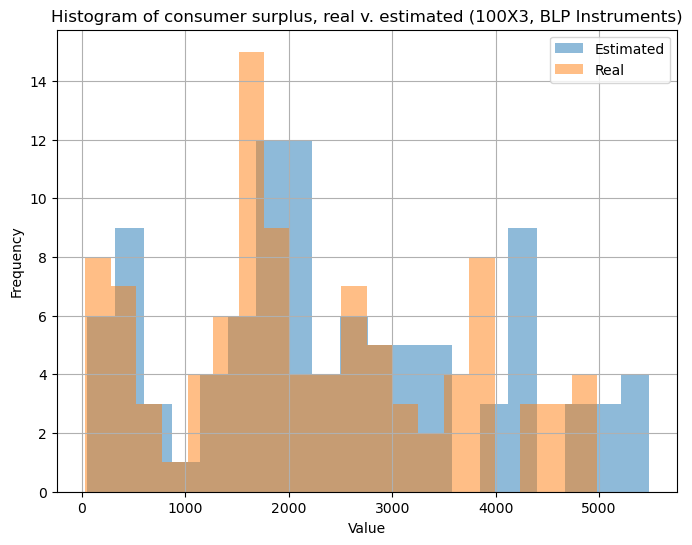

Estimated price elasticity (100X3, BLP instruments)
[[-6.82762668e+00  4.01158071e-04  5.38919889e-04 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 1.69092017e+00 -4.06749111e-01  1.70164626e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 4.65191473e-01  3.48473091e-01 -2.17177573e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 ...
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ... -2.32689974e+00
   1.42010351e-01  1.13916111e-01]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ...  6.56399071e-01
  -1.90565714e+00  5.23801039e-01]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ...  1.11067899e+00
   1.10489703e+00 -5.17365377e-01]]


In [4]:
# Pre-question, loading libraries and data
from scipy.io import loadmat
import jaxopt as jaxopt
from PSET4_functions.misc import *
from PSET4_functions.shares import *
from PSET4_functions.delta import *
from PSET4_functions.moments import * 
from PSET4_functions.mpec_wrapper import *

m100_j3 = loadmat("data/100markets3products.mat")
dat = clean_data(m100_j3, 3)
# dat = pd.read_csv("data/100markets3products.csv")
z_data = blp_instruments(dat[['X1jm', 'X2jm', 'X3jm']].to_numpy().reshape(100,3,3)) 
np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy() 
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()
demand_features_data_long = dat[["X1jm", "X2jm", "X3jm", "pjm", "xijm"]].to_numpy()

shares_data_wide = shares_data_long.reshape(100,3)

prices_data_wide = prices_data_long.reshape(100,3)

x_data_3d = x_data_long.reshape(100, 3, 3)

# ESTIMATING PARAMETERS

theta_2_0 = np.array([1]) 
delta_0 = inner_loop(theta_2_0, logit_delta(shares_data_wide).reshape(100, 3), shares_data_wide, prices_data_wide, random_vs)
dat[["delta_0"]] = delta_0.reshape(-1,1)
beta, alpha, sigma_alpha, delta_hat = full_mpec_wrapper(theta_2_0, dat, z_data, random_vs, 100, 3)

# RECOVERING ANALYTIC SEs
beta_alpha_se, sigma_alpha_se = standard_errors(sigma_alpha, delta_hat, z_data, prices_data_wide, x_data_long, x_data_3d, random_vs)


results = [["beta_1", beta[0], beta_alpha_se[0]], 
           ["beta_2", beta[1], beta_alpha_se[1]], 
           ["beta_3", beta[2], beta_alpha_se[2]], 
           ["-alpha", alpha, beta_alpha_se[3]], 
           ["sigma_alpha", sigma_alpha, sigma_alpha_se]]
headers = ["estimates", "standard errors"]
print("Results (100X3, BLP instruments)")
print(tabulate(results, headers, tablefmt="plain"))

demand_features_data_long = dat[["X1jm", "X2jm", "X3jm", "pjm", "xijm"]].to_numpy()

est_shares = shares(sigma_alpha, delta_hat, prices_data_wide, random_vs)
ds_ddelta = shares_ddelta(sigma_alpha, delta_hat, prices_data_wide, random_vs)
ddelta_dp = alpha 
est_price_elasticity = (prices_data_long/est_shares)*(ds_ddelta * ddelta_dp) # p/s * ds/dp = p/s * ds/ddelta * ddelta/dp

est_consumer_surplus = consumer_surplus((beta[0], beta[1], beta[2], alpha, sigma_alpha), demand_features_data_long, random_vs, 3)
real_consumer_surplus = consumer_surplus((5, 1, 1, -1, 1), demand_features_data_long, random_vs, 3)

est_v_real_cs = np.concatenate([est_consumer_surplus.reshape(-1,1), real_consumer_surplus.reshape(-1,1)], axis = 1)

cs_graph_labs = ['Estimated', 'Real']

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))

for i in range(est_v_real_cs.shape[1]):
    plt.hist(est_v_real_cs[:, i], bins=20, alpha=0.5, label=cs_graph_labs[i])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of consumer surplus, real v. estimated (100X3, BLP Instruments)')
plt.legend()
plt.grid(True)
plt.show()

print("Estimated price elasticity (100X3, BLP instruments)")
print(est_price_elasticity)

In [5]:
m10_j3 = loadmat("data/10markets3products.mat")
dat = clean_data(m10_j3, 3)
z_data = blp_instruments(dat[['X1jm', 'X2jm', 'X3jm']].to_numpy().reshape(10,3,3)) 
np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy() 
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()

shares_data_wide = shares_data_long.reshape(10,3)

prices_data_wide = prices_data_long.reshape(10,3)

x_data_3d = x_data_long.reshape(10, 3, 3)

# ESTIMATING PARAMETERS

theta_2_0 = np.array([1]) 
delta_0 = inner_loop(theta_2_0, logit_delta(shares_data_wide).reshape(10, 3), shares_data_wide, prices_data_wide, random_vs)
dat[["delta_0"]] = delta_0.reshape(-1,1)
beta, alpha, sigma_alpha, delta_hat = full_mpec_wrapper(theta_2_0, dat, z_data, random_vs, 10, 3)

# RECOVERING ANALYTIC SEs
beta_alpha_se, sigma_alpha_se = standard_errors(sigma_alpha, delta_hat, z_data, prices_data_wide, x_data_long, x_data_3d, random_vs)


results = [["beta_1", beta[0], beta_alpha_se[0]], 
           ["beta_2", beta[1], beta_alpha_se[1]], 
           ["beta_3", beta[2], beta_alpha_se[2]], 
           ["-alpha", alpha, beta_alpha_se[3]], 
           ["sigma_alpha", sigma_alpha, sigma_alpha_se]]
headers = ["estimates", "standard errors"]
print("Results (10X3, BLP Instruments)")
print(tabulate(results, headers, tablefmt="plain"))

Results (10X3, BLP Instruments)
               estimates    standard errors
beta_1          3.18572          0.010616
beta_2          0.422597         0.00270523
beta_3          1.17424          0.0163304
-alpha         -1.47284          0.111379
sigma_alpha     0.1              0.0674513


/Users/jacobgosselin/miniforge3/envs/MacM3Env/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [6]:
m100_j3 = loadmat("data/100markets3products.mat")
dat = clean_data(m100_j3, 3)

shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy() 
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()

shares_data_wide = shares_data_long.reshape(100,3)

prices_data_wide = prices_data_long.reshape(100,3)

x_data_3d = x_data_long.reshape(100, 3, 3)

blp_data = blp_instruments(x_data_3d) 
hausman_data = hausman_instruments(prices_data_wide)

z_data = np.concatenate([blp_data, hausman_data.reshape(-1,1)], axis=1)

np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

# ESTIMATING PARAMETERS

theta_2_0 = np.array([1]) 
delta_0 = inner_loop(theta_2_0, logit_delta(shares_data_wide).reshape(100, 3), shares_data_wide, prices_data_wide, random_vs)
dat[["delta_0"]] = delta_0.reshape(-1,1)

beta, alpha, sigma_alpha, delta_hat = full_mpec_wrapper(theta_2_0, dat, z_data, random_vs, 100, 3)

# RECOVERING ANALYTIC SEs
beta_alpha_se, sigma_alpha_se = standard_errors(sigma_alpha, delta_hat, z_data, prices_data_wide, x_data_long, x_data_3d, random_vs)

print("Results(100X3, BLP and Hausman Instruments)")
results = [["beta_1", beta[0], beta_alpha_se[0]], 
           ["beta_2", beta[1], beta_alpha_se[1]], 
           ["beta_3", beta[2], beta_alpha_se[2]], 
           ["-alpha", alpha, beta_alpha_se[3]], 
           ["sigma_alpha", sigma_alpha, sigma_alpha_se]]
headers = ["estimates", "standard errors"]
print(tabulate(results, headers, tablefmt="plain"))

Results(100X3, BLP and Hausman Instruments)
               estimates    standard errors
beta_1          5.00925          0.0455117
beta_2          0.966493         0.0082439
beta_3          1.03453          0.00643605
-alpha         -0.966936         0.00273145
sigma_alpha     1.01788          0.0167873


## 2.3

Going to be honest, a bit disappointed that this doesn't mess up my estimates more (though it does bias them visibly). I'm sure if I played around with it I could get weirder values given initial guesses, but I'm endless hours deep at this point and still struggling with 3.2.c. I mean ex-ante it's obvious price can't be used as an instrument (very clear cut endogeneity).

In [7]:
# Pre-question, loading libraries and data
from scipy.io import loadmat
import jaxopt as jaxopt
from PSET4_functions.misc import *
from PSET4_functions.shares import *
from PSET4_functions.delta import *
from PSET4_functions.moments import * 
from PSET4_functions.mpec_wrapper import *

m100_j3 = loadmat("data/100markets3products.mat")
dat = clean_data(m100_j3, 3)

shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy() 
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()

shares_data_wide = shares_data_long.reshape(100,3)

prices_data_wide = prices_data_long.reshape(100,3)

x_data_3d = x_data_long.reshape(100, 3, 3)

blp_data = blp_instruments(x_data_3d) 
bad_instruments = prices_data_long

z_data = np.concatenate([blp_data, bad_instruments.reshape(-1,1)], axis=1)

np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

# ESTIMATING PARAMETERS

theta_2_0 = np.array([1]) 
delta_0 = inner_loop(theta_2_0, logit_delta(shares_data_wide).reshape(100, 3), shares_data_wide, prices_data_wide, random_vs)
dat[["delta_0"]] = delta_0.reshape(-1,1)

beta, alpha, sigma_alpha, delta_hat = full_mpec_wrapper(theta_2_0, dat, z_data, random_vs, 100, 3)

# RECOVERING ANALYTIC SEs
beta_alpha_se, sigma_alpha_se = standard_errors(sigma_alpha, delta_hat, z_data, prices_data_wide, x_data_long, x_data_3d, random_vs)

print("Results (100X3, BLP instruments and P)")
results = [["beta_1", beta[0], beta_alpha_se[0]], 
           ["beta_2", beta[1], beta_alpha_se[1]], 
           ["beta_3", beta[2], beta_alpha_se[2]], 
           ["-alpha", alpha, beta_alpha_se[3]], 
           ["sigma_alpha", sigma_alpha, sigma_alpha_se]]
headers = ["estimates", "standard errors"]
print(tabulate(results, headers, tablefmt="plain"))

Results (100X3, BLP instruments and P)
               estimates    standard errors
beta_1          4.78388          0.0492257
beta_2          0.922144         0.00889384
beta_3          1.01855          0.00689911
-alpha         -0.915417         0.00288976
sigma_alpha     0.991043         0.0181011


# Question 3 

## 3.1 

a) As usual, my moments are $E[\xi | Z] = 0$, for BLP instruments and cost shifter W, i.e. $Z = \{x_{1jm}, x_{2jm}, x_{3jm}, \sum_{k \neq j} x_{2km}, \sum_{k \neq j} x_{3km}, W_j\}$

b,c) See results below

d) Same story as before: 100X3 estimates are pretty good, 10X3 are very bad. Again, I'm confused as to why this doesn't show up the SEs. Compared to just using the BLP instruments, I converge faster to better results when I add cost shifter $W_j$ as an instrument (which is exactly what you'd expect, since it's a great instrument).

In [9]:
# Pre-question, loading libraries and data
from scipy.io import loadmat
import jaxopt as jaxopt
from PSET4_functions.misc import *
from PSET4_functions.shares import *
from PSET4_functions.delta import *
from PSET4_functions.moments import * 
from PSET4_functions.mpec_wrapper import *

m100_j3 = loadmat("data/100markets3products.mat")
dat = clean_data(m100_j3, 3)

shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy() 
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()
w_data_long = dat[['wj']].to_numpy()

shares_data_wide = shares_data_long.reshape(100,3)

prices_data_wide = prices_data_long.reshape(100,3)

x_data_3d = x_data_long.reshape(100, 3, 3)

blp_data = blp_instruments(x_data_3d) 
cost_shifter_data = w_data_long

z_data = np.concatenate([blp_data, cost_shifter_data.reshape(-1,1)], axis=1)

np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

# ESTIMATING PARAMETERS

theta_2_0 = np.array([1]) 
delta_0 = inner_loop(theta_2_0, logit_delta(shares_data_wide).reshape(100, 3), shares_data_wide, prices_data_wide, random_vs)
dat[["delta_0"]] = delta_0.reshape(-1,1)

beta, alpha, sigma_alpha, delta_hat = full_mpec_wrapper(theta_2_0, dat, z_data, random_vs, 100, 3)

# RECOVERING ANALYTIC SEs
beta_alpha_se, sigma_alpha_se = standard_errors(sigma_alpha, delta_hat, z_data, prices_data_wide, x_data_long, x_data_3d, random_vs)

print("Results (100X3, BLP instruments and cost shifter W)")
results = [["beta_1", beta[0], beta_alpha_se[0]], 
           ["beta_2", beta[1], beta_alpha_se[1]], 
           ["beta_3", beta[2], beta_alpha_se[2]], 
           ["-alpha", alpha, beta_alpha_se[3]], 
           ["sigma_alpha", sigma_alpha, sigma_alpha_se]]
headers = ["estimates", "standard errors"]
print(tabulate(results, headers, tablefmt="plain"))

Results (100X3, BLP instruments and cost shifter W)
               estimates    standard errors
beta_1          5.04149          0.0451664
beta_2          0.972842         0.0081834
beta_3          1.03681          0.00639871
-alpha         -0.974329         0.00273361
sigma_alpha     1.0217           0.0166797


In [10]:
m10_j3 = loadmat("data/10markets3products.mat")
dat = clean_data(m10_j3, 3)

shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy() 
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()
w_data_long = dat[['wj']].to_numpy()

shares_data_wide = shares_data_long.reshape(10,3)

prices_data_wide = prices_data_long.reshape(10,3)

x_data_3d = x_data_long.reshape(10, 3, 3)

blp_data = blp_instruments(x_data_3d) 
cost_shifter_data = w_data_long

z_data = np.concatenate([blp_data, cost_shifter_data.reshape(-1,1)], axis=1)

np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

# ESTIMATING PARAMETERS

theta_2_0 = np.array([1]) 
delta_0 = inner_loop(theta_2_0, logit_delta(shares_data_wide).reshape(10, 3), shares_data_wide, prices_data_wide, random_vs)
dat[["delta_0"]] = delta_0.reshape(-1,1)

beta, alpha, sigma_alpha, delta_hat = full_mpec_wrapper(theta_2_0, dat, z_data, random_vs, 10, 3)

# RECOVERING ANALYTIC SEs
beta_alpha_se, sigma_alpha_se = standard_errors(sigma_alpha, delta_hat, z_data, prices_data_wide, x_data_long, x_data_3d, random_vs)

print("Results (10X3, BLP instruments and cost shifter W)")
results = [["beta_1", beta[0], beta_alpha_se[0]], 
           ["beta_2", beta[1], beta_alpha_se[1]], 
           ["beta_3", beta[2], beta_alpha_se[2]], 
           ["-alpha", alpha, beta_alpha_se[3]], 
           ["sigma_alpha", sigma_alpha, sigma_alpha_se]]
headers = ["estimates", "standard errors"]
print(tabulate(results, headers, tablefmt="plain"))

Results (10X3, BLP instruments and cost shifter W)
               estimates    standard errors
beta_1          3.00907           0.111968
beta_2          0.570964          0.0336515
beta_3          1.61983           0.0155125
-alpha          0.522694          0.0944406
sigma_alpha     1.45839           0.0987571


## 3.2

a) Marginal cost is price minus Bertrand markup, i.e. $ mc_{jt} = p_{jt} - b_{jt}(\mathbb{P}_{t}, \mathbb{S}_{t}, \theta_2) $. The Bertrand markup is $b(\mathbb{P}_{t}, \mathbb{S}_{t}, \theta_2) = (- \mathbb{H}_t \odot \frac{ds}{dp}(p_t))^{-1} \mathbb{S}_t(\mathbb{P}_t)$, where $\mathbb{H}_t$ is the ownership matrix. Marginal costs under different forms of oligopoly or monopoly follows this formula, but the ownership matrix changes, i.e. for perfect collusion the ownership matrix is all 1s (every firm "owns" every product); for oligopoly, the true model, it's the identity matrix (each firm owns their own product). Obviously under perfect competition we can skip all this (there is no mark-up, marginal cost = price).

b) I use the BLP instruments + cost shifter estimate, i.e. my results from 3.1. It seems the most stable, and converges the fastest; plus the most compelling instrument is a cost shifter W (best satisfies relevance and exclusion assumptions in most cases). I plot a overlayed histogram of my estimated marginal costs and the real ones; pretty pleased with how well things line up. Seems like there is some downward skew on the estimate, but overall just looks like the statistical noise you'd expect of an estimated vs. real value. 

c) I tried so hard, but I've been defeated (for now; maybe with a fresh mind I can figure this out over break). Somewhere along the line of trying to get my Jacobian right I keep getting a 3D tensor product, which I somehow need to collapse into a 2D Jacobian, but I don't understand how. Or maybe I'm doing something wrong, which is quite possible. Weird to me that in all the papers and appendices (Nevo 2001 practicioner guide, Dube Fox Su, etc...) I can't find clear guidance on how to do the joint estimation; maybe I've missed something. Sadly my brain is fried from weeks of this, so I don't think there's any chance I catch whatever mistake I have. Still learned a lot struggling with this PSET, and really really really enjoyed this class; thank you so much Gaston!

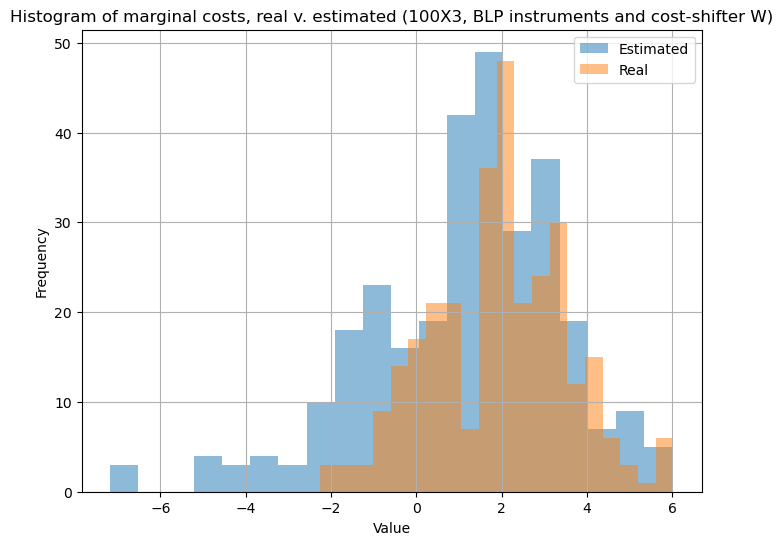

In [11]:
# Pre-question, loading libraries and data
from scipy.io import loadmat
import jaxopt as jaxopt
from PSET4_functions.misc import *
from PSET4_functions.shares import *
from PSET4_functions.delta import *
from PSET4_functions.moments import * 
from PSET4_functions.mpec_wrapper import *

m100_j3 = loadmat("data/100markets3products.mat")
dat = clean_data(m100_j3, 3)

shares_data_long = dat[['sjm']].to_numpy()
prices_data_long = dat[['pjm']].to_numpy() 
x_data_long = dat[['X1jm', 'X2jm', 'X3jm']].to_numpy()
w_data_long = dat[['wj']].to_numpy()
supply_features_data_long = dat[['wj', 'zjm', 'etajm']].to_numpy()

shares_data_wide = shares_data_long.reshape(100,3)

prices_data_wide = prices_data_long.reshape(100,3)

x_data_3d = x_data_long.reshape(100, 3, 3)

blp_data = blp_instruments(x_data_3d) 
cost_shifter_data = w_data_long

z_data = np.concatenate([blp_data, cost_shifter_data.reshape(-1,1)], axis=1)

np.random.seed(456)
random_vs = np.random.lognormal(0, 1, 1000)

# Estimating parameters

theta_2_0 = np.array([1]) 
delta_0 = inner_loop(theta_2_0, logit_delta(shares_data_wide).reshape(100, 3), shares_data_wide, prices_data_wide, random_vs)
dat[["delta_0"]] = delta_0.reshape(-1,1)

beta, alpha, sigma_alpha, delta_hat = full_mpec_wrapper(theta_2_0, dat, z_data, random_vs, 100, 3)

# Estimating marginal cost for oligopoly (correct model)
ds_dp = alpha * shares_ddelta(sigma_alpha, delta_hat, prices_data_wide, random_vs) 
ownership_matrix = np.eye(300) 
markup = np.linalg.solve(np.multiply(-1 * ownership_matrix, ds_dp), np.eye(300)) @ shares_data_long
est_marginal_cost = prices_data_long - markup

real_marginal_cost = marginal_cost((2,1,1), supply_features_data_long, 3)


est_v_real_marginal_cost = np.concatenate((est_marginal_cost, real_marginal_cost.reshape(-1,1)), axis=1)

mc_graph_labs = ['Estimated', 'Real']

# Plot overlapping histograms for each column
plt.figure(figsize=(8, 6))

for i in range(est_v_real_marginal_cost.shape[1]):
    plt.hist(est_v_real_marginal_cost[:, i], bins=20, alpha=0.5, label=mc_graph_labs[i])

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of marginal costs, real v. estimated (100X3, BLP instruments and cost-shifter W)')
plt.legend()
plt.grid(True)
plt.show()